In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.dates as mdates

In [6]:
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')
    df['Arrival Time'] = pd.to_datetime(df['Arrival Time'], format='%H:%M').dt.time
    df['arrival_hour'] = df['Arrival Time'].apply(lambda x: x.hour)
    df['arrival_minute'] = df['Arrival Time'].apply(lambda x: x.minute)
    df['arrival_minutes_after_noon'] = df['arrival_hour'] * 60 + df['arrival_minute'] - (12 * 60)
    weekday_map = {
        'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
        'Friday': 4, 'Saturday': 5, 'Sunday': 6
    }
    df['day_of_week'] = df['Week Day'].map(weekday_map)
    df = pd.get_dummies(df, columns=['Weather'], drop_first=True)
    return df

df = load_and_preprocess_data(file_path)

In [7]:
def visualize_data(df):
    df['arrival_minutes_after_noon'] = df['arrival_hour'] * 60 + df['arrival_minute'] - (12 * 60)
    plt.figure(figsize=(12, 6))
    plt.scatter(df['Date'], df['arrival_minutes_after_noon'], label='Arrival Time (minutes after noon)', alpha=0.6)
    plt.xlabel('Date')
    plt.ylabel('Arrival Time (minutes after noon)')
    plt.title('Bus Arrival Time Distribution (Afternoon)')
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    weather_columns = [col for col in df.columns if 'Weather_' in col]
    for weather_col in weather_columns:
        df.boxplot(column='arrival_minutes_after_noon', by=weather_col)
        plt.title(f'Impact of {weather_col} on Afternoon Arrival Time')
        plt.xlabel('Weather Condition')
        plt.ylabel('Arrival Time (minutes after noon)')
        plt.show()
        


In [8]:
def train_and_optimize_model(df):
    feature_cols = ['day_of_week', 'arrival_hour', 'arrival_minute'] + [col for col in df.columns if 'Weather_' in col]
    X = df[feature_cols]
    y = df['arrival_minutes_after_noon']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_absolute_error')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Optimized Mean Absolute Error (MAE): {mae:.2f} minutes')
    return best_model

In [9]:
def predict_afternoon_arrivals(model, day_of_week, weather_condition, start_hour=12, end_hour=18, interval=15):
    arrival_minutes = list(range((start_hour - 12) * 60, (end_hour - 12) * 60, interval))
    predictions = []
    for minute_after_noon in arrival_minutes:
        hour = (minute_after_noon // 60) + 12
        minute = minute_after_noon % 60
        input_data = {
            'day_of_week': [day_of_week],
            'arrival_hour': [hour],
            'arrival_minute': [minute]
        }
        for col in model.feature_names_in_:
            if col.startswith('Weather_'):
                input_data[col] = [0]
        if weather_condition in input_data:
            input_data[weather_condition] = [1]
        input_df = pd.DataFrame(input_data)
        predicted_minutes_after_noon = model.predict(input_df)[0]
        predicted_hour = int(predicted_minutes_after_noon // 60) + 12
        predicted_minute = int(predicted_minutes_after_noon % 60)
        predicted_time = f"{predicted_hour:02d}:{predicted_minute:02d}"
        predictions.append(predicted_time)
    consolidated_predictions = []
    for time in predictions:
        if not consolidated_predictions or abs(int(time.split(":")[0]) * 60 + int(time.split(":")[1]) -
                                              int(consolidated_predictions[-1].split(":")[0]) * 60 -
                                              int(consolidated_predictions[-1].split(":")[1])) >= interval:
            consolidated_predictions.append(time)
    return consolidated_predictions

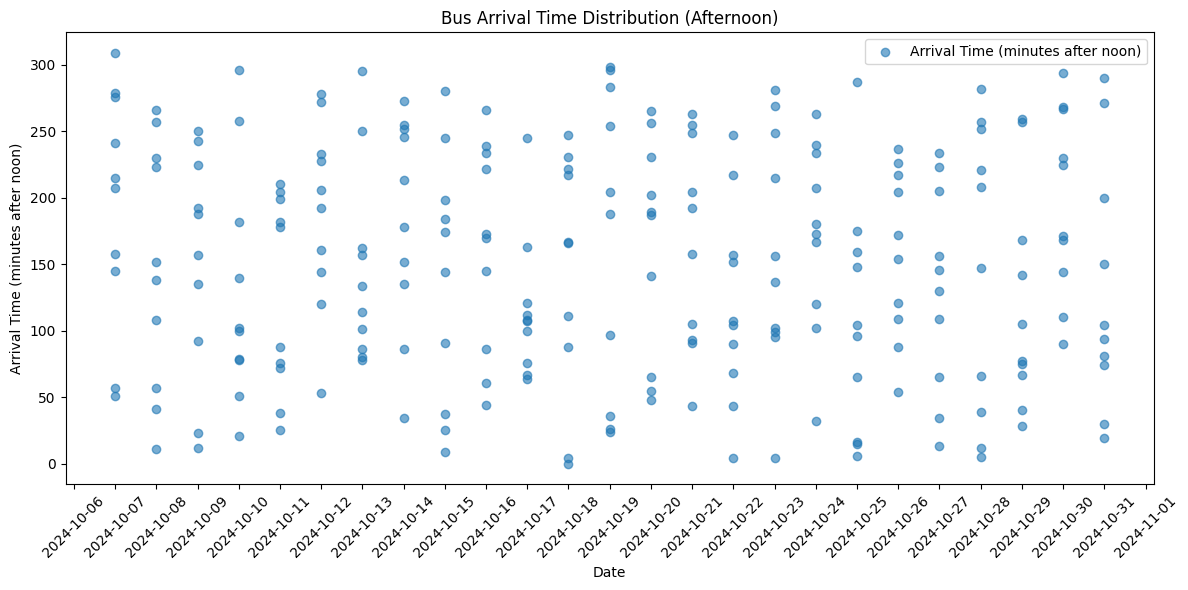

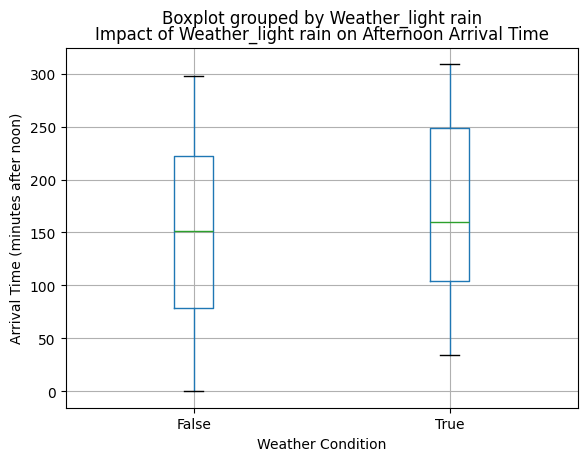

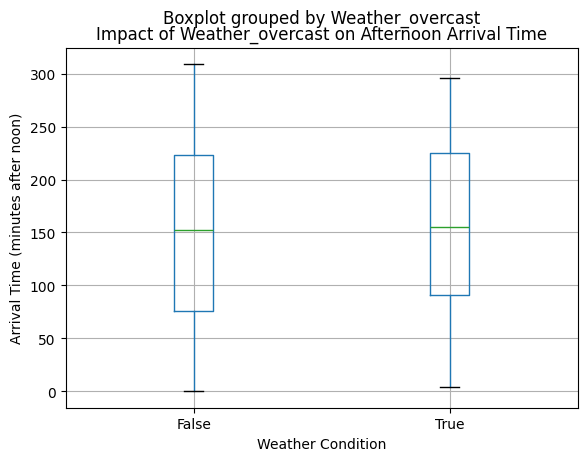

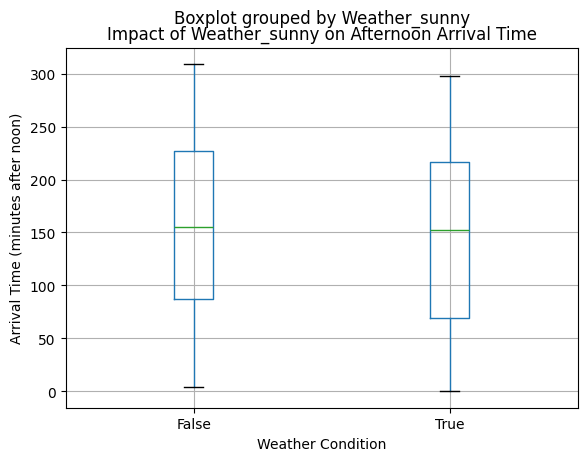

Optimized Mean Absolute Error (MAE): 2.19 minutes
Predicted Afternoon Arrival Times:
12:02
12:30
13:02
13:29
13:44
14:00
14:15
14:46
15:02
15:29
15:44
16:01
16:28
16:01
16:28


In [10]:
if __name__ == "__main__":
    file_path = 'bus_arrival_schedule.csv'
    df = load_and_preprocess_data(file_path)
    visualize_data(df)
    model = train_and_optimize_model(df)
    predicted_times = predict_afternoon_arrivals(model, day_of_week=0, weather_condition='Weather_light rain')
    print("Predicted Afternoon Arrival Times:")
    for time in predicted_times:
        print(time)

